In [2]:
import os
import cv2 

1. Data Setup

In [3]:
image_dir = "./images"
images, labels = [], []

for file_name in os.listdir(image_dir):
    parts = os.path.splitext(file_name)[0].split("_")
    if len(parts) != 4 or any(p == "" for p in parts):
        continue

    age, gender, race, date = int(parts[0]), int(parts[1]), int(parts[2]), parts[3]
    if not (0 <= age <= 116 and gender in (0, 1) and 0 <= race <= 4 and len(date) == 17):
        continue

    img_path = os.path.join(image_dir, file_name)
    img = cv2.imread(img_path)

    images.append(img)
    labels.append({
        "age": age,
        "gender": gender,
        "race": race,
        "datetime": date
    })

print(len(images))

24099


2. Data Exploration & Visualisation

In [4]:
import random
import matplotlib.pyplot as plt
import seaborn as sns

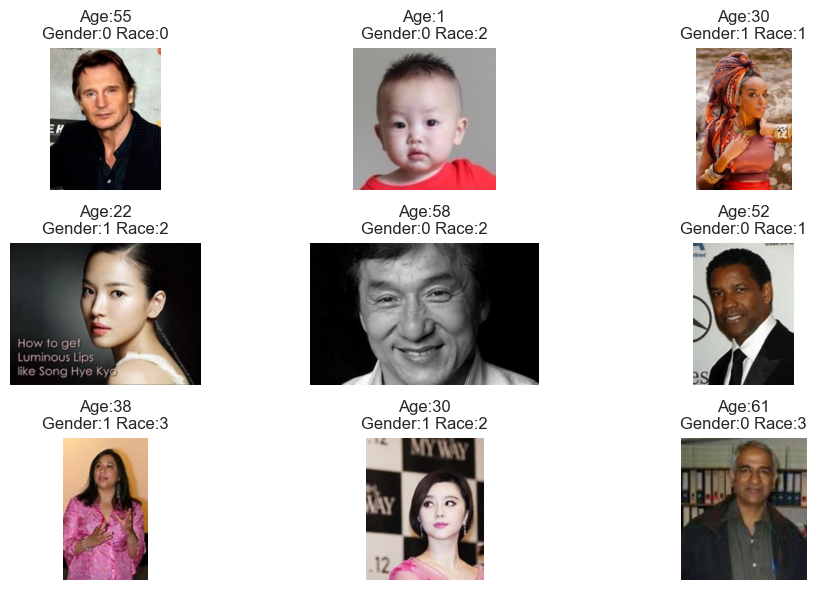

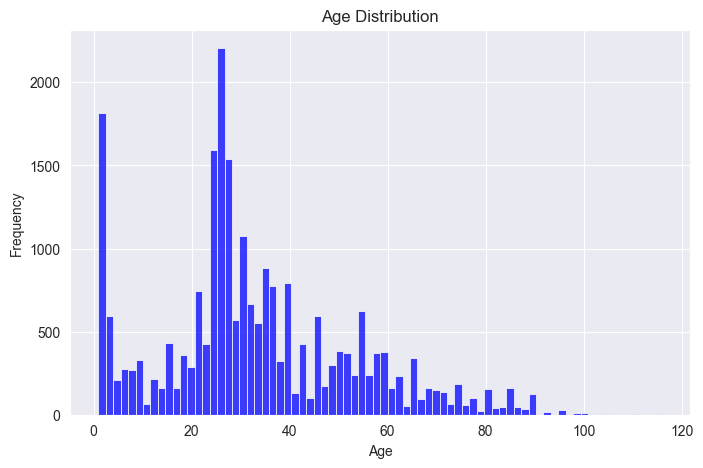

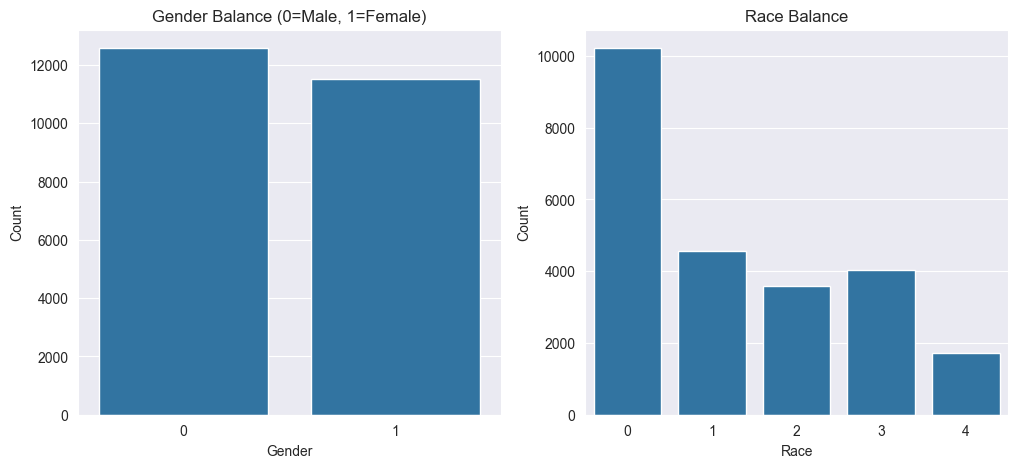

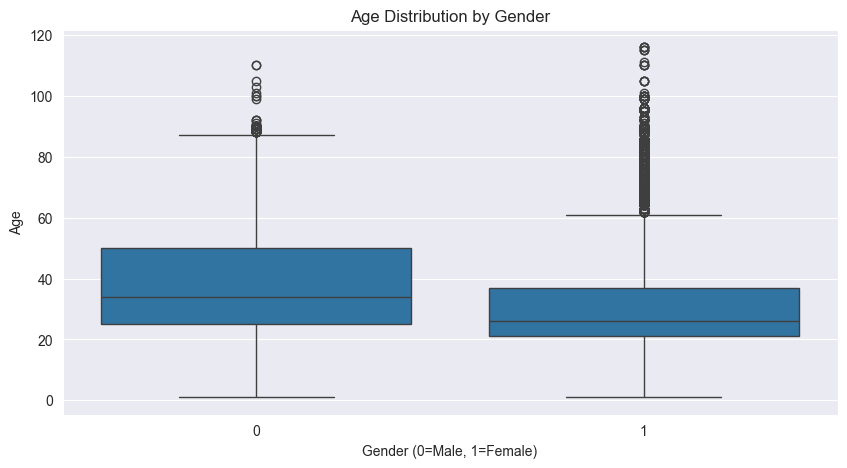

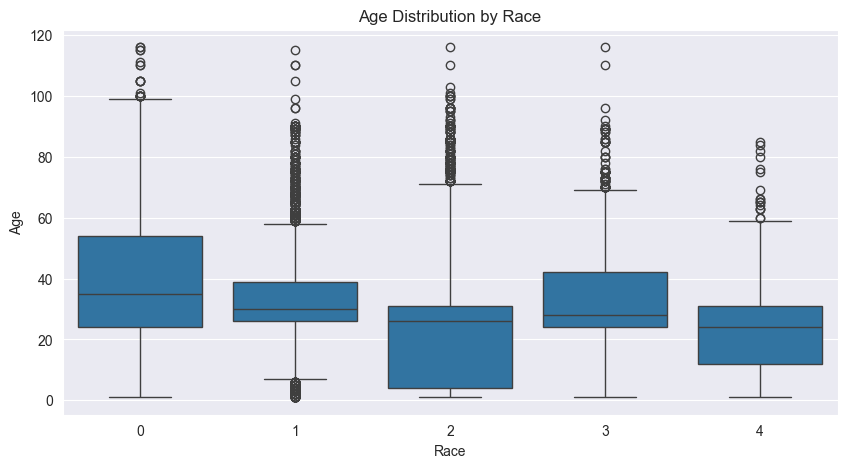

In [5]:
# Visualize random sample
plt.figure(figsize=(10, 6))
for i in range(9):  # show 9 random images
    idx = random.randint(0, len(images) - 1)
    img = images[idx]
    label = labels[idx]

    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # convert BGR -> RGB for matplotlib
    plt.axis("off")
    plt.title(f'Age:{label["age"]}\nGender:{label["gender"]} Race:{label["race"]}')
plt.tight_layout()
plt.show()

# Plot age distribution (histogram)
genders = [i["gender"] for i in labels]
races = [i["race"] for i in labels]
age_list = [i["age"] for i in labels]

plt.figure(figsize=(8, 5))
sns.histplot(age_list, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Check class balance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=genders, ax=axes[0])
axes[0].set_title("Gender Balance (0=Male, 1=Female)")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Count")

sns.countplot(x=races, ax=axes[1])
axes[1].set_title("Race Balance")
axes[1].set_xlabel("Race")
axes[1].set_ylabel("Count")

plt.show()

# Identify potential biases (e.g., gender, ethnicity, lighting)
plt.figure(figsize=(10, 5))
sns.boxplot(x=genders, y=[i["age"] for i in labels])
plt.title("Age Distribution by Gender")
plt.xlabel("Gender (0=Male, 1=Female)")
plt.ylabel("Age")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=races, y=[i["age"] for i in labels])
plt.title("Age Distribution by Race")
plt.xlabel("Race")
plt.ylabel("Age")
plt.show()

3. Data Preprocessing

In [10]:
# for memory-safe preprocessing
# FREE RAM (safe to run even if vars don't exist)
import gc
for name in ["X", "X_tmp", "X_train", "X_val", "X_test", "dbg_X", "dbg_y", "dbg_w"]:
    if name in globals():
        del globals()[name]
gc.collect()

import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

# reproducibility
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# preprocessing settings
TARGET_SIZE = (224, 224)    # (W, H). If RAM is super tight, use (160,160) or (128,128)
NORMALIZE_01 = True         # we'll scale to [0,1] in the generator
STANDARDIZE = False         # optional: apply (x-mean)/std after normalization (see 3.F)

# split ratios
TEST_SIZE = 0.15
VAL_SIZE  = 0.15  # of total

# stratification bins
AGE_BINS = [0, 5, 12, 18, 30, 45, 60, 80, 200]

# sanity check that points 1–2 ran:
assert "images" in globals() and "labels" in globals(), "Run your dataset loading first (points 1–2)."

In [11]:
# LABEL ARRAYS
ages    = np.array([d["age"]    for d in labels], dtype=np.float32)  # regression target
genders = np.array([d["gender"] for d in labels], dtype=np.int32)
races   = np.array([d["race"]   for d in labels], dtype=np.int32)

print(f"N={len(ages)} samples")

N=24099 samples


In [12]:
# STREAM PREPROCESS -> MEMMAP (avoids huge RAM use)

out_shape = (len(images), TARGET_SIZE[1], TARGET_SIZE[0], 3)  # (N, H, W, 3)
mm_path = "preprocessed_images.dat"

# Create memmap for writing
X_mm = np.memmap(mm_path, dtype=np.uint8, mode='w+', shape=out_shape)

def to_rgb_resized_uint8(img_bgr, target_size=TARGET_SIZE):
    img = cv2.resize(img_bgr, target_size, interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img  # uint8

CHUNK = 256
for start in range(0, len(images), CHUNK):
    end = min(start + CHUNK, len(images))
    for i in range(start, end):
        X_mm[i] = to_rgb_resized_uint8(images[i])
    X_mm.flush()

# Free original full-res images to reclaim RAM
images = None
gc.collect()

print("Memmap written:", X_mm.shape, X_mm.dtype, "->", mm_path)

Memmap written: (24099, 224, 224, 3) uint8 -> preprocessed_images.dat


In [13]:
# STRATIFIED SPLIT BY AGE BINS (indices only; data stays on disk)
bins_idx = np.digitize(ages, AGE_BINS, right=False) - 1
idx_all = np.arange(len(ages))

# test split
idx_tmp, idx_test, ages_tmp, ages_test, bins_tmp, bins_test = train_test_split(
    idx_all, ages, bins_idx,
    test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=bins_idx
)

# val split from remainder
val_ratio_of_remaining = VAL_SIZE / (1.0 - TEST_SIZE)
idx_train, idx_val, ages_train, ages_val, bins_train, bins_val = train_test_split(
    idx_tmp, ages_tmp, bins_tmp,
    test_size=val_ratio_of_remaining, random_state=RANDOM_SEED, stratify=bins_tmp
)

print("Counts -> train/val/test:", len(idx_train), len(idx_val), len(idx_test))
print("Bin counts (train):", Counter(bins_train))
print("Bin counts (val):  ", Counter(bins_val))
print("Bin counts (test): ", Counter(bins_test))

Counts -> train/val/test: 16869 3615 3615
Bin counts (train): Counter({3: 5408, 4: 4007, 5: 2363, 0: 1682, 6: 1434, 1: 807, 2: 679, 7: 489})
Bin counts (val):   Counter({3: 1159, 4: 859, 5: 506, 0: 361, 6: 307, 1: 173, 2: 145, 7: 105})
Bin counts (test):  Counter({3: 1159, 4: 859, 5: 506, 0: 361, 6: 307, 1: 173, 2: 145, 7: 105})


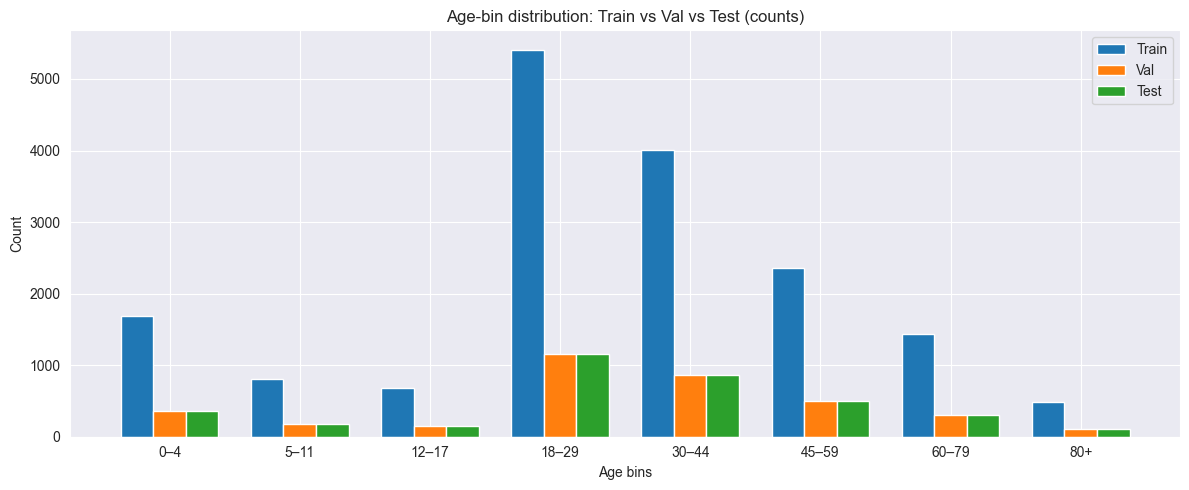

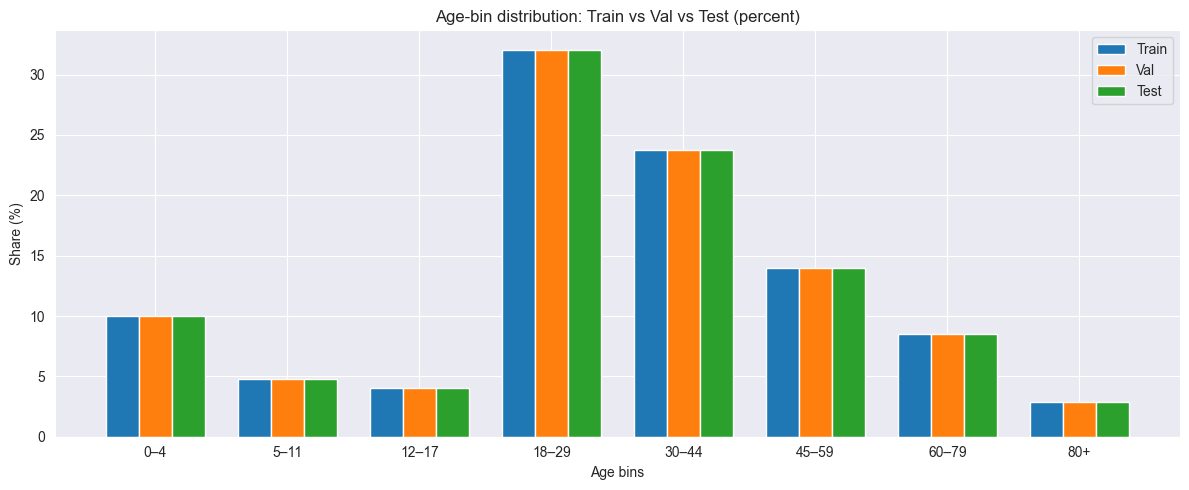

In [20]:
# VISUALIZE STRATIFIED SPLITS: counts + percentages by age bin

# 1) Build ordered counts per bin
K = len(AGE_BINS) - 1  # number of bins
bin_labels = []
for i in range(K):
    lo, hi = AGE_BINS[i], AGE_BINS[i+1]
    if i < K - 1:
        bin_labels.append(f"{lo}–{hi-1}")
    else:
        bin_labels.append(f"{lo}+")

def counts_in_order(counter, K):
    return np.array([counter.get(i, 0) for i in range(K)], dtype=np.int32)

train_counts = counts_in_order(Counter(bins_train), K)
val_counts   = counts_in_order(Counter(bins_val),   K)
test_counts  = counts_in_order(Counter(bins_test),  K)

# 2) Plot raw counts (side-by-side bars)
x = np.arange(K)
w = 0.25

plt.figure(figsize=(12, 5))
plt.bar(x - w, train_counts, width=w, label="Train")
plt.bar(x,       val_counts, width=w, label="Val")
plt.bar(x + w, test_counts,  width=w, label="Test")
plt.xticks(x, bin_labels, rotation=0)
plt.xlabel("Age bins")
plt.ylabel("Count")
plt.title("Age-bin distribution: Train vs Val vs Test (counts)")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Plot normalized percentages (so the shapes should look almost identical across splits)
train_pct = (train_counts / train_counts.sum()) * 100.0
val_pct   = (val_counts   / val_counts.sum())   * 100.0
test_pct  = (test_counts  / test_counts.sum())  * 100.0

plt.figure(figsize=(12, 5))
plt.bar(x - w, train_pct, width=w, label="Train")
plt.bar(x,       val_pct, width=w, label="Val")
plt.bar(x + w, test_pct,  width=w, label="Test")
plt.xticks(x, bin_labels, rotation=0)
plt.xlabel("Age bins")
plt.ylabel("Share (%)")
plt.title("Age-bin distribution: Train vs Val vs Test (percent)")
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
# AUGMENTATION UTILS
def random_hflip(img_uint8, p=0.5):
    if rng.random() < p:
        return np.ascontiguousarray(img_uint8[:, ::-1, :])
    return img_uint8

def random_rotate(img_uint8, max_deg=10):
    deg = float(rng.uniform(-max_deg, max_deg))
    h, w = img_uint8.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), deg, 1.0)
    return cv2.warpAffine(img_uint8, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

def random_crop_and_resize(img_uint8, scale=(0.88, 1.0)):
    h, w = img_uint8.shape[:2]
    s = float(rng.uniform(scale[0], scale[1]))
    new_h, new_w = int(h * s), int(w * s)
    max_y = max(h - new_h, 0); max_x = max(w - new_w, 0)
    y0 = int(rng.integers(0, max_y + 1)) if max_y > 0 else 0
    x0 = int(rng.integers(0, max_x + 1)) if max_x > 0 else 0
    crop = img_uint8[y0:y0 + new_h, x0:x0 + new_w, :]
    return cv2.resize(crop, (w, h), interpolation=cv2.INTER_AREA)

def random_brightness_contrast(img_f, b_lim=0.15, c_lim=0.15, p=0.8):
    if rng.random() > p:
        return img_f
    brightness = float(rng.uniform(-b_lim, b_lim))
    contrast   = 1.0 + float(rng.uniform(-c_lim, c_lim))
    out = img_f * contrast + brightness
    return np.clip(out, 0.0, 1.0)

def add_gaussian_noise(img_f, sigma=0.02, p=0.3):
    if rng.random() > p:
        return img_f
    noise = rng.normal(0.0, sigma, img_f.shape).astype(np.float32)
    out = img_f + noise
    return np.clip(out, 0.0, 1.0)

def augment_once(img_uint8):
    # geometric ops on uint8, then photometric on float
    y = random_hflip(img_uint8, p=0.5)
    y = random_rotate(y, max_deg=10)
    y = random_crop_and_resize(y, scale=(0.88, 1.0))
    y = y.astype(np.float32) / 255.0 if NORMALIZE_01 else y.astype(np.float32)
    y = random_brightness_contrast(y, b_lim=0.15, c_lim=0.15, p=0.8)
    y = add_gaussian_noise(y, sigma=0.02, p=0.3)
    return y

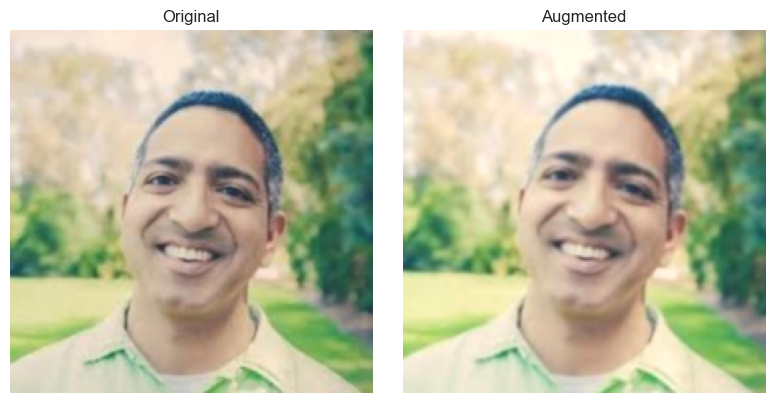

In [23]:
# quick check: one image (original vs augmented)

# reopen memmap in case of kernel restarts
X_mm = np.memmap(mm_path, dtype=np.uint8, mode='r', shape=out_shape)

i = int(rng.integers(0, len(idx_train)))        # random training index (in split space)
j = idx_train[i]                                 # actual dataset index
orig = X_mm[j]                                   # uint8 RGB
aug  = augment_once(orig)                        # float32 in [0,1]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(orig); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(aug);  plt.title("Augmented"); plt.axis("off")
plt.tight_layout(); plt.show()


In [15]:
# SAMPLE WEIGHTS (inverse-frequency by bin)
def make_sample_weights(bins):
    counts = Counter(bins)
    n = len(bins); K = len(counts)
    return np.array([n / (K * counts[b]) for b in bins], dtype=np.float32)

train_weights = make_sample_weights(bins_train)
print("Example weights:", train_weights[:10])

Example weights: [0.38990846 1.2536415  0.52623534 4.3121166  0.38990846 1.2536415
 0.89235085 0.52623534 0.89235085 0.52623534]


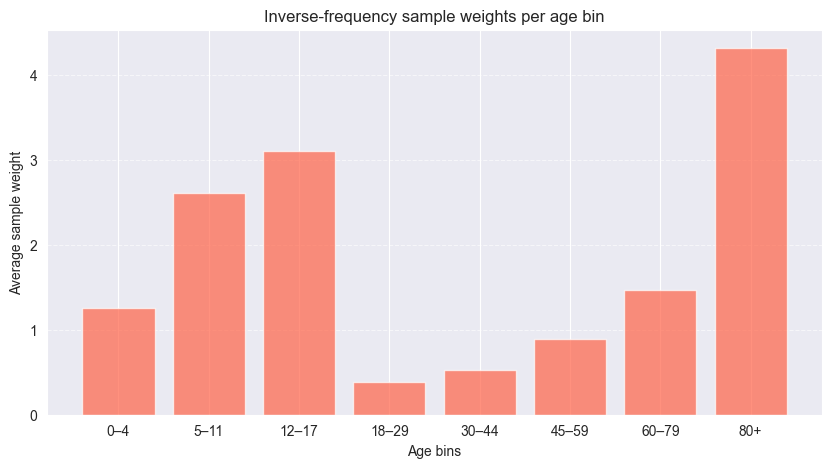

In [24]:
#average weight per bin (so we can see how weighting scales each age group)
unique_bins = sorted(set(bins_train))
avg_weights = [train_weights[np.array(bins_train) == b].mean() for b in unique_bins]

bin_labels = []
for i in unique_bins:
    lo, hi = AGE_BINS[i], AGE_BINS[i+1]
    if i < len(AGE_BINS) - 2:
        bin_labels.append(f"{lo}–{hi-1}")
    else:
        bin_labels.append(f"{lo}+")

plt.figure(figsize=(10,5))
plt.bar(bin_labels, avg_weights, color="tomato", alpha=0.7)
plt.xlabel("Age bins")
plt.ylabel("Average sample weight")
plt.title("Inverse-frequency sample weights per age bin")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

In [16]:
# BATCH GENERATORS FROM MEMMAP

# reopen memmap in read-only mode (robust if kernel restarts)
X_mm = np.memmap(mm_path, dtype=np.uint8, mode='r', shape=out_shape)

def train_batch_generator(idx_array, y_array, sample_weights=None, batch_size=32, shuffle=True):
    n = len(idx_array)
    order = np.arange(n)
    while True:
        if shuffle:
            rng.shuffle(order)
        for start in range(0, n, batch_size):
            sel = order[start:start+batch_size]
            idxs = idx_array[sel]
            bx = np.empty((len(idxs),) + X_mm.shape[1:], dtype=np.float32)
            for i, j in enumerate(idxs):
                bx[i] = augment_once(X_mm[j])
            by = y_array[sel]
            if sample_weights is not None:
                bw = sample_weights[sel]
                yield bx, by, bw
            else:
                yield bx, by

def val_batch_iterator(idx_array, y_array, batch_size=32):
    # No augmentation for val/test
    n = len(idx_array)
    for start in range(0, n, batch_size):
        sel = idx_array[start:start+batch_size]
        bx = (X_mm[sel].astype(np.float32) / 255.0) if NORMALIZE_01 else X_mm[sel].astype(np.float32)
        by = y_array[start:start+batch_size]
        yield bx, by

# Debug one batch:
dbg_gen = train_batch_generator(idx_train, ages_train, sample_weights=train_weights, batch_size=8)
dbg_X, dbg_y, dbg_w = next(dbg_gen)
print("Debug batch:", dbg_X.shape, dbg_y.shape, dbg_w.shape, dbg_X.dtype)

Debug batch: (8, 224, 224, 3) (8,) (8,) float32


In [25]:
import torch

X_t = torch.from_numpy(dbg_X).permute(0, 3, 1, 2)  # NHWC -> NCHW
y_t = torch.from_numpy(dbg_y).float()
w_t = torch.from_numpy(dbg_w).float()

print(X_t.shape, y_t.shape, w_t.shape)  # -> torch.Size([8, 3, 224, 224]) torch.Size([8]) torch.Size([8])

torch.Size([8, 3, 224, 224]) torch.Size([8]) torch.Size([8])


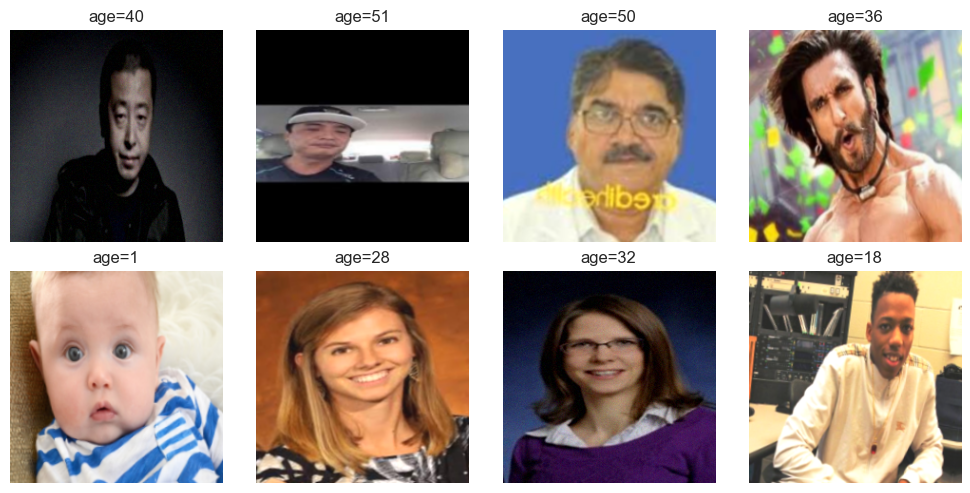

In [26]:
fig, axes = plt.subplots(2, 4, figsize=(10,5))
for ax, img, age in zip(axes.ravel(), dbg_X, dbg_y):
    ax.imshow(img)                 # img already in RGB [0,1]
    ax.set_title(f"age={int(age)}")
    ax.axis("off")
plt.tight_layout(); plt.show()

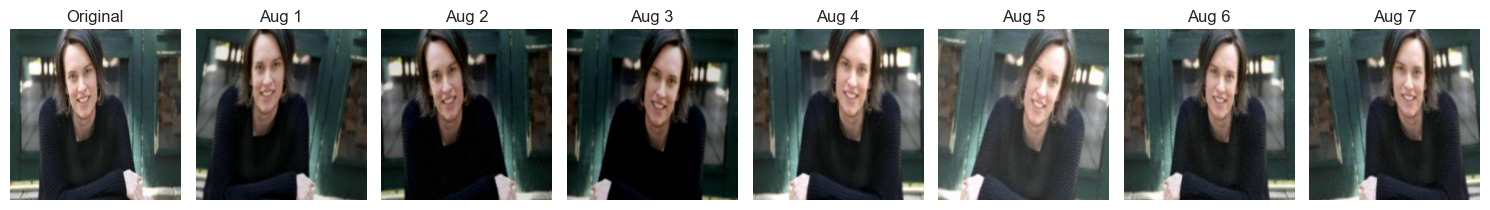

In [28]:
X_mm = np.memmap(mm_path, dtype=np.uint8, mode='r', shape=out_shape)

# Pick one random training sample
j = int(rng.choice(idx_train))
orig = X_mm[j]

# Show original + k augmentations
k = 7
plt.figure(figsize=(15, 4))

plt.subplot(1, k+1, 1)
plt.imshow(orig)
plt.title("Original")
plt.axis("off")

for i in range(k):
    aug = augment_once(orig)
    plt.subplot(1, k+1, i+2)
    plt.imshow(aug)
    plt.title(f"Aug {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [29]:
# MEAN/STD (for STANDARDIZE=True later)
sum_ = np.zeros(3, dtype=np.float64)
sum_sq = np.zeros(3, dtype=np.float64)
count = 0

CHUNK = 512
for start in range(0, len(X_mm), CHUNK):
    end = min(start + CHUNK, len(X_mm))
    batch = X_mm[start:end].astype(np.float32) / 255.0
    sum_   += batch.sum(axis=(0,1,2))
    sum_sq += (batch**2).sum(axis=(0,1,2))
    count  += (batch.shape[0] * batch.shape[1] * batch.shape[2])

channel_mean = (sum_ / count).astype(np.float32)
channel_var  = (sum_sq / count) - (channel_mean**2)
channel_std  = np.sqrt(np.maximum(channel_var, 1e-12)).astype(np.float32)

print("Channel mean:", channel_mean, "std:", channel_std)

Channel mean: [0.5391406  0.46926507 0.43062425] std: [0.29134881 0.2902778  0.29893693]


In [30]:
# PyTorch adapter for generators
def torchify_batch(batch):
    # convert (numpy arrays) -> (torch tensors)
    if len(batch) == 3:  # with sample weights
        X, y, w = batch
        return (torch.from_numpy(X).permute(0, 3, 1, 2),  # NHWC -> NCHW
                torch.from_numpy(y).float(),
                torch.from_numpy(w).float())
    else:
        X, y = batch
        return (torch.from_numpy(X).permute(0, 3, 1, 2),
                torch.from_numpy(y).float())

# Example: get one batch from a train generator
dbg_gen = train_batch_generator(idx_train, ages_train,
                                sample_weights=train_weights,
                                batch_size=16)

X_np, y_np, w_np = next(dbg_gen)
X_t, y_t, w_t = torchify_batch((X_np, y_np, w_np))

print("Torch batch shapes:", X_t.shape, y_t.shape, w_t.shape)

Torch batch shapes: torch.Size([16, 3, 224, 224]) torch.Size([16]) torch.Size([16])
